<a href="https://colab.research.google.com/github/robertpetre/DSM/blob/main/DSM%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("cjinny/mura-v11")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/cjinny/mura-v11/versions/1


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import cv2
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
root_path = "/root/.cache/kagglehub/datasets/cjinny/mura-v11/versions/1/"

csv_path = os.path.join(root_path, "MURA-v1.1/train_image_paths.csv")
csv_path_test = os.path.join(root_path, "MURA-v1.1/valid_image_paths.csv")

df = pd.read_csv(csv_path)
df_test = pd.read_csv(csv_path_test)


filtered_df = df[df.iloc[:, 0].apply(lambda x: x.split("/")[2] == "XR_FOREARM")]
filtered_df_test = df_test[df_test.iloc[:, 0].apply(lambda x: x.split("/")[2] == "XR_FOREARM")]

filtered_dict = {
    image_path: 1 if "positive" in image_path else 0
    for image_path in filtered_df.iloc[:, 0]
}

filtered_dict_test = {
    image_path: 1 if "positive" in image_path else 0
    for image_path in filtered_df_test.iloc[:, 0]
}

In [4]:
transforms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [5]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.GaussianBlur(image, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    image = np.uint8(np.absolute(sobel_edges))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    return image

In [6]:
class BoneFracture(Dataset):
    def __init__(self, root_path, transform=None, preprocess=False):
        self.root_path = root_path
        self.transform = transform
        self.preprocess = preprocess
        self.dataset_dict = filtered_dict
        self.image_paths = list(self.dataset_dict.keys())
        self.labels = list(self.dataset_dict.values())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image_path = self.image_paths[idx]
      label = self.labels[idx]
      full_image_path = os.path.join(self.root_path, image_path)

      if self.preprocess:
          image = preprocess_image(full_image_path)
          image = Image.fromarray(image)
      else:
          image = Image.open(full_image_path).convert("L")

      if self.transform:
          image = self.transform(image)

      return image, label

In [7]:
augmentations = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor(),
])

In [8]:
train_dataset = BoneFracture(root_path=root_path, transform=transforms)

class_1_indices = [idx for idx, label in enumerate(train_dataset.labels) if label == 1]

augmented_images = []
augmented_labels = []

for idx in class_1_indices:
    image_path = train_dataset.image_paths[idx]
    full_image_path = os.path.join(root_path, image_path)
    image = Image.open(full_image_path).convert("L")

    augmented_image = augmentations(image)
    augmented_images.append(augmented_image)
    augmented_labels.append(1)

train_dataset.image_paths += [train_dataset.image_paths[idx] for idx in class_1_indices]
train_dataset.labels += [train_dataset.labels[idx] for idx in class_1_indices]

image_paths = train_dataset.image_paths
labels = train_dataset.labels

test_dataset = BoneFracture(root_path=root_path, transform=transforms)
test_image_paths = test_dataset.image_paths
test_labels = test_dataset.labels

train_indices, val_indices = train_test_split(
    np.arange(len(image_paths)),
    test_size=0.2,
    stratify=labels
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_labels = [train_dataset.labels[idx] for idx in train_indices]
val_labels = [train_dataset.labels[idx] for idx in val_indices]

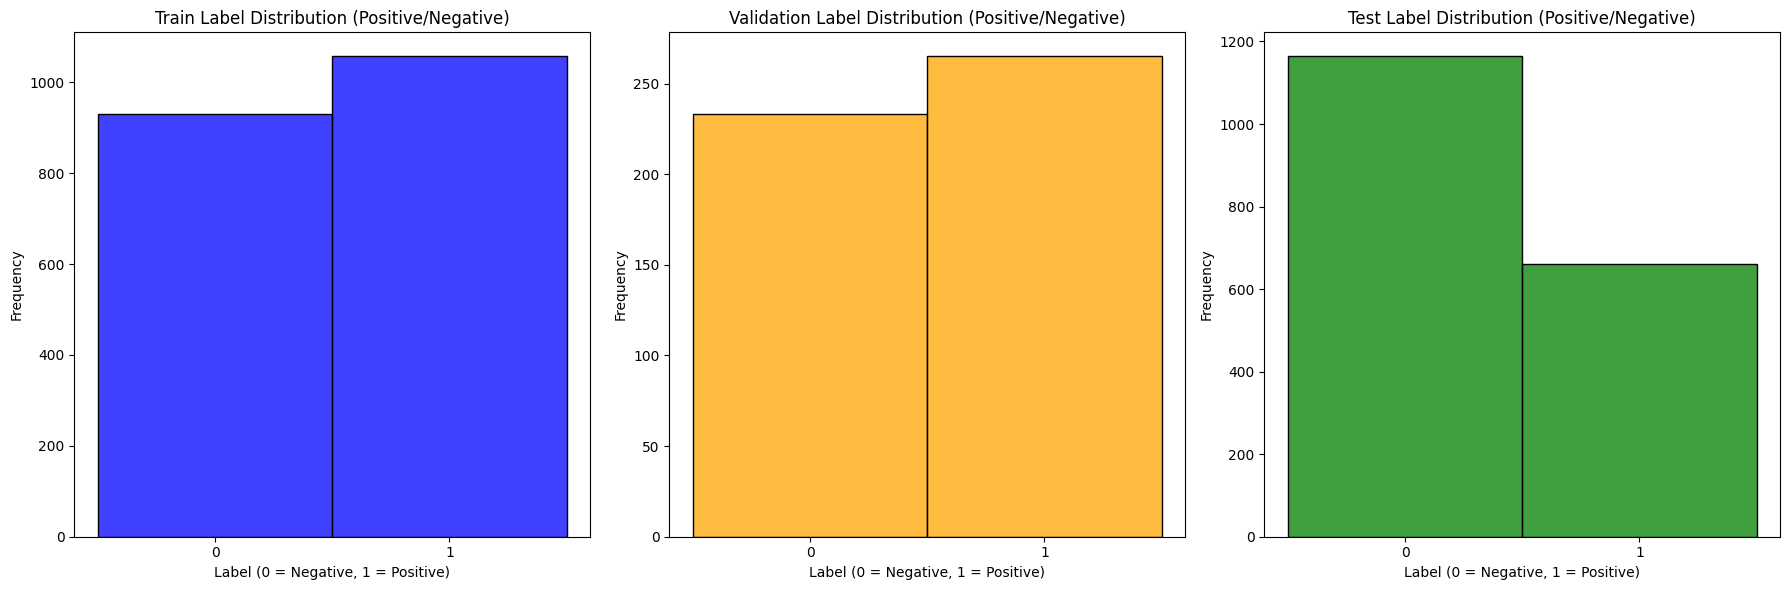

Train Label counts: Counter({1: 1057, 0: 931})
Validation Label counts: Counter({1: 265, 0: 233})
Test Label counts: Counter({0: 1164, 1: 661})


In [9]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(train_labels, bins=2, kde=False, color='blue', discrete=True)
plt.title("Train Label Distribution (Positive/Negative)")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1])

plt.subplot(1, 3, 2)
sns.histplot(val_labels, bins=2, kde=False, color='orange', discrete=True)
plt.title("Validation Label Distribution (Positive/Negative)")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1])

plt.subplot(1, 3, 3)
sns.histplot(test_labels, bins=2, kde=False, color='green', discrete=True)
plt.title("Test Label Distribution (Positive/Negative)")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1])

plt.tight_layout()
plt.show()

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

print(f"Train Label counts: {train_label_counts}")
print(f"Validation Label counts: {val_label_counts}")
print(f"Test Label counts: {test_label_counts}")

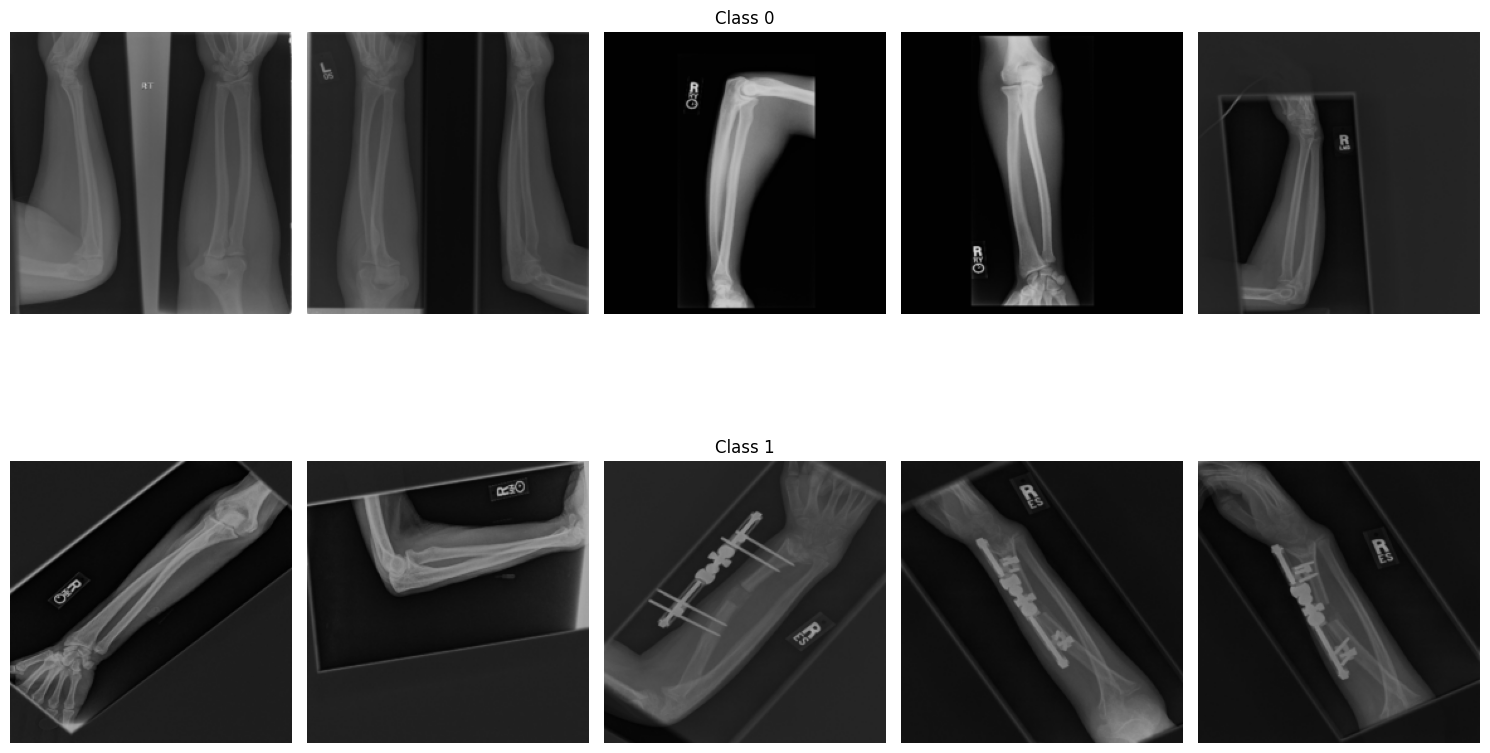

In [10]:
def display_sample_images(dataset, num_classes, num_images_per_class=5):
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))

    class_images = {i: [] for i in range(num_classes)}
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        class_images[label].append(image)

    for i in range(num_classes):
        class_name = f"Class {i}"
        for j in range(num_images_per_class):
            if j < len(class_images[i]):
                image = class_images[i][j]

                image = image.permute(1, 2, 0).numpy()

                axes[i, j].imshow(image, cmap="gray")
                axes[i, j].axis('off')
                if j == 2:
                    axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

display_sample_images(train_dataset, num_classes=2)

In [11]:
def check_image_modes(dataset):
    non_rgb_count = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)

        try:
            image = Image.open(full_image_path)
            if image.mode != "RGB":
                non_rgb_count += 1
        except FileNotFoundError:
            print(f"File not found: {full_image_path}")

    return non_rgb_count

non_rgb_train = check_image_modes(train_dataset)

print(f"Non-RGB images in training dataset: {non_rgb_train}")


Non-RGB images in training dataset: 986


In [12]:
def square_images(dataset):
    count = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)
        image = Image.open(full_image_path)
        width, height = image.size
        if width != height:
            count += 1

    return count

train_non_square = square_images(train_dataset)

print(f"Non-square images in training dataset: {train_non_square}")

Non-square images in training dataset: 2370


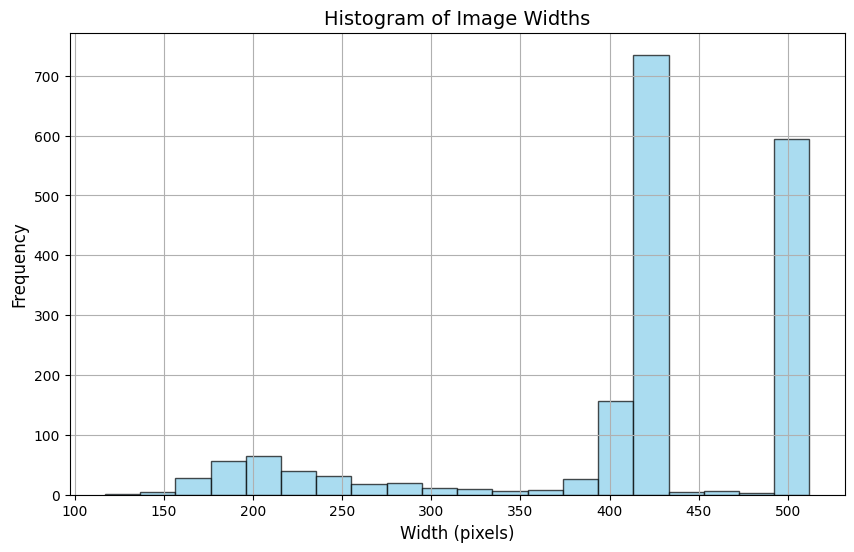

In [13]:
def get_image_width(image_path):
    image = Image.open(image_path)
    return image.width

widths = []

for img_path in filtered_dict.keys():
    full_image_path = os.path.join(root_path, img_path)
    try:
        width = get_image_width(full_image_path)
        widths.append(width)
    except FileNotFoundError:
        print(f"File not found: {full_image_path}")
        continue

plt.figure(figsize=(10, 6))
plt.hist(widths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Image Widths', fontsize=14)
plt.xlabel('Width (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

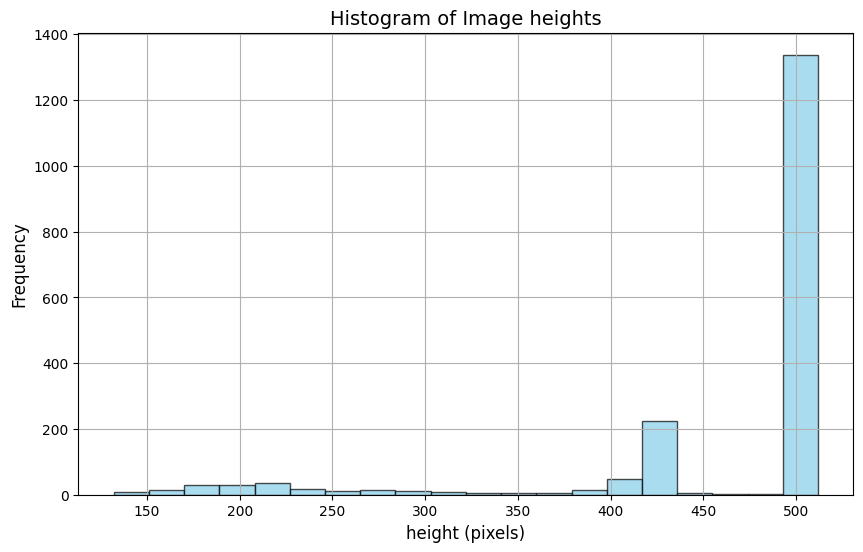

In [14]:
def get_image_height(image_path):
    image = Image.open(image_path)
    return image.height

heights = []

for img_path in filtered_dict.keys():
    full_image_path = os.path.join(root_path, img_path)
    try:
        height = get_image_height(full_image_path)
        heights.append(height)
    except FileNotFoundError:
        print(f"File not found: {full_image_path}")
        continue

plt.figure(figsize=(10, 6))
plt.hist(heights, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Image heights', fontsize=14)
plt.xlabel('height (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

In [15]:
def img_pixel_range(dataset):
    min_val = 0
    max_val = 255
    count_images = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)
        image = Image.open(full_image_path)
        image = np.array(image)
        if np.min(image) < min_val:
            count_images += 1
        if np.max(image) > max_val:
            count_images += 1

    return count_images

train_out_range = img_pixel_range(train_dataset)

print(f"Images with pixel values outside [0, 255] in training dataset: {train_out_range}")

Images with pixel values outside [0, 255] in training dataset: 0


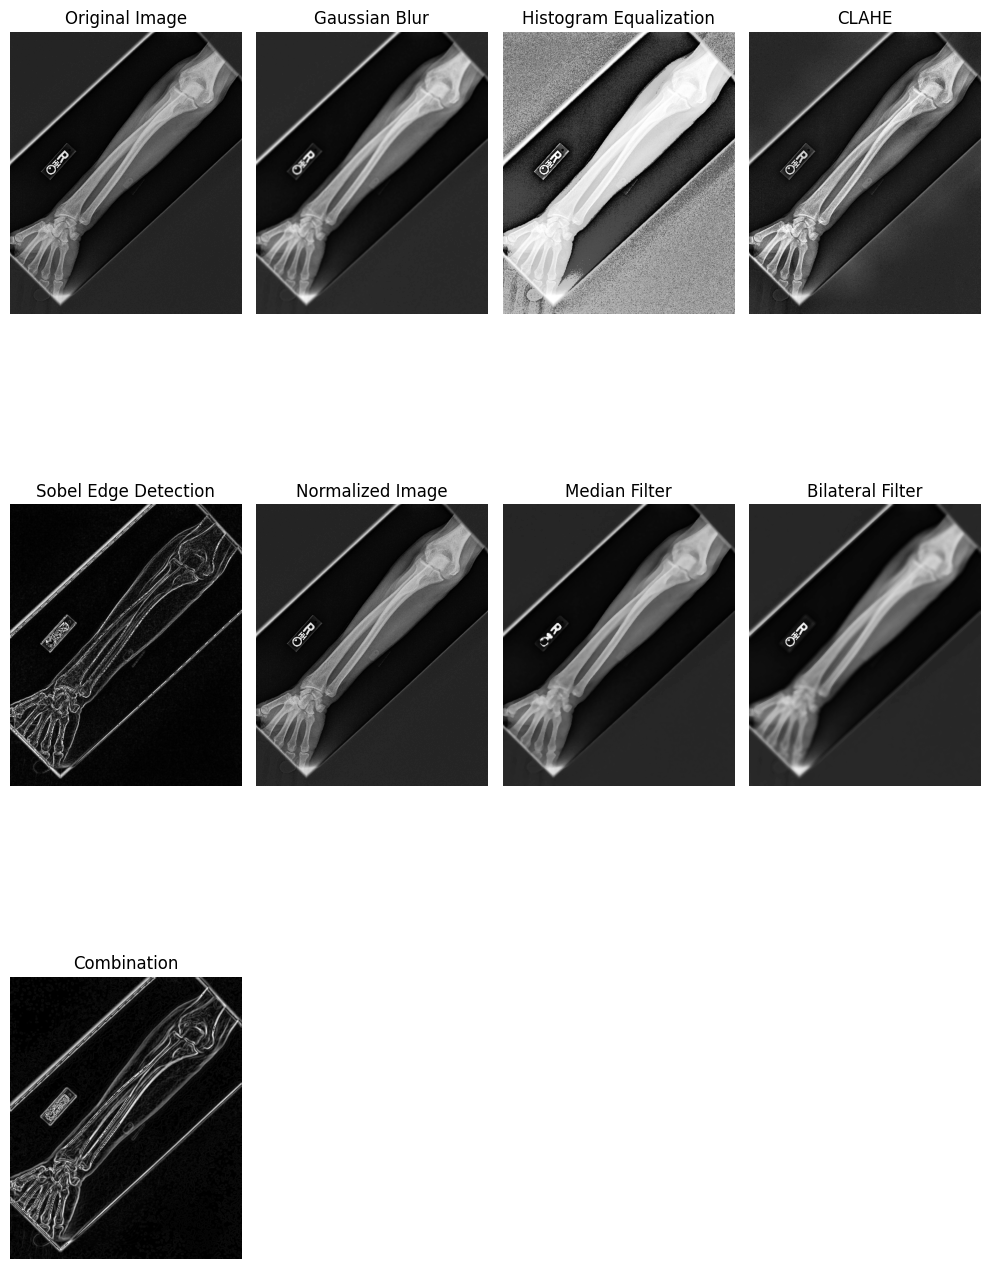

In [16]:
image_path = os.path.join(root_path, train_dataset.image_paths[0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def display_images(images, titles, figsize=(10, 15)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(3, int(len(images) / 2), i+1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def sobel_edge_detection(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    return np.uint8(np.absolute(sobel_edges))

def normalize_intensity(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def median_filter(image):
    return cv2.medianBlur(image, 5)

def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

gaussian_blurred = gaussian_blur(image)
hist_eq = histogram_equalization(image)
clahe_image = clahe(image)
sobel_edges = sobel_edge_detection(image)
normalized_image = normalize_intensity(image)
median_filtered = median_filter(image)
bilateral_filtered = bilateral_filter(image)

combination = gaussian_blur(image)
combination = clahe(combination)
combination = sobel_edge_detection(combination)
combination = normalize_intensity(combination)

images = [
    image, gaussian_blurred, hist_eq, clahe_image, sobel_edges,
    normalized_image, median_filtered, bilateral_filtered, combination
]

titles = [
    'Original Image', 'Gaussian Blur', 'Histogram Equalization', 'CLAHE',
    'Sobel Edge Detection', 'Normalized Image', 'Median Filter', 'Bilateral Filter', 'Combination'
]

display_images(images, titles)

In [17]:
use_cuda = torch.cuda.is_available()
device = "cuda"

In [18]:
from transformers import ViTImageProcessor, ViTModel

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [19]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [21]:
train_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)
val_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)
test_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)

train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset.image_paths)),
    test_size=0.2,
    stratify=train_dataset.labels
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch

class ViTClassifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super(ViTClassifier, self).__init__()
        self.vit = model
        self.classifier = Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(pixel_values=x).last_hidden_state[:, 0]
        return self.classifier(outputs)

num_classes = 2
vit_classifier = ViTClassifier(model, num_classes=num_classes)
vit_classifier.to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(vit_classifier.parameters(), lr=1e-4)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return acc, precision, recall, f1, conf_matrix

test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(vit_classifier, test_loader)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)

100%|██████████| 58/58 [00:36<00:00,  1.60it/s]

Test Accuracy: 0.6121
Test Precision: 0.3484
Test Recall: 0.0817
Test F1 Score: 0.1324
Confusion Matrix:
[[1063  101]
 [ 607   54]]


# **fine-tuning 1**

In [23]:
from torch.utils.data import DataLoader
import time

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, val_loader, num_epochs=10):
    best_val_accuracy = 0.0
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train_samples += labels.size(0)

        train_accuracy = train_correct / total_train_samples

        model.eval()
        val_correct = 0
        val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val_samples += labels.size(0)

        val_accuracy = val_correct / total_val_samples
        val_loss /= total_val_samples
        train_loss /= total_train_samples

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_vit_classifier.pth")

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{num_epochs}, Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

num_epochs = 10
train_model(vit_classifier, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/10 [Validation]: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch 1/10, Time: 75.33s
Train Loss: 0.5296, Train Accuracy: 0.7555
Validation Loss: 0.4047, Validation Accuracy: 0.8356


Epoch 2/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 2/10, Time: 75.79s
Train Loss: 0.3708, Train Accuracy: 0.8534
Validation Loss: 0.3551, Validation Accuracy: 0.8795


Epoch 3/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch 3/10, Time: 70.74s
Train Loss: 0.2821, Train Accuracy: 0.8932
Validation Loss: 0.3842, Validation Accuracy: 0.8466


Epoch 4/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch 4/10, Time: 69.90s
Train Loss: 0.1592, Train Accuracy: 0.9452
Validation Loss: 0.3739, Validation Accuracy: 0.8685


Epoch 5/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch 5/10, Time: 69.26s
Train Loss: 0.0926, Train Accuracy: 0.9726
Validation Loss: 0.6984, Validation Accuracy: 0.8082


Epoch 6/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch 6/10, Time: 69.46s
Train Loss: 0.0936, Train Accuracy: 0.9685
Validation Loss: 0.4623, Validation Accuracy: 0.8630


Epoch 7/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 7/10, Time: 69.06s
Train Loss: 0.0363, Train Accuracy: 0.9911
Validation Loss: 0.4979, Validation Accuracy: 0.8658


Epoch 8/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 8/10, Time: 69.84s
Train Loss: 0.0231, Train Accuracy: 0.9938
Validation Loss: 0.5510, Validation Accuracy: 0.8630


Epoch 9/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 9/10, Time: 69.63s
Train Loss: 0.0602, Train Accuracy: 0.9836
Validation Loss: 0.4893, Validation Accuracy: 0.8548


Epoch 10/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Epoch 10/10, Time: 69.74s
Train Loss: 0.0249, Train Accuracy: 0.9932
Validation Loss: 0.6637, Validation Accuracy: 0.8575
Best Validation Accuracy: 0.8795


In [24]:
vit_classifier.load_state_dict(torch.load("best_vit_classifier.pth"))

test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(vit_classifier, test_loader)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)


<ipython-input-24-3df5fb884029>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_classifier.load_state_dict(torch.load("best_vit_classifier.pth"))
100%|██████████| 58/58

Test Accuracy: 0.9068
Test Precision: 0.9270
Test Recall: 0.8064
Test F1 Score: 0.8625
Confusion Matrix:
[[1122   42]
 [ 128  533]]


# **fine-tuning 2**

In [25]:
optimizer = Adam(vit_classifier.parameters(), lr=0.00001)

vit_classifier.to(device)

num_epochs = 10
train_model(vit_classifier, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch 1/10, Time: 75.28s
Train Loss: 0.2332, Train Accuracy: 0.9226
Validation Loss: 0.3288, Validation Accuracy: 0.8795


Epoch 2/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch 2/10, Time: 70.24s
Train Loss: 0.1673, Train Accuracy: 0.9527
Validation Loss: 0.3351, Validation Accuracy: 0.8740


Epoch 3/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Epoch 3/10, Time: 72.99s
Train Loss: 0.1238, Train Accuracy: 0.9664
Validation Loss: 0.3446, Validation Accuracy: 0.8877


Epoch 4/10 [Validation]: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch 4/10, Time: 69.37s
Train Loss: 0.0872, Train Accuracy: 0.9822
Validation Loss: 0.3798, Validation Accuracy: 0.8658


Epoch 5/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch 5/10, Time: 69.42s
Train Loss: 0.0725, Train Accuracy: 0.9829
Validation Loss: 0.4050, Validation Accuracy: 0.8712


Epoch 6/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Epoch 6/10, Time: 69.70s
Train Loss: 0.0499, Train Accuracy: 0.9911
Validation Loss: 0.4119, Validation Accuracy: 0.8740


Epoch 7/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch 7/10, Time: 69.59s
Train Loss: 0.0390, Train Accuracy: 0.9938
Validation Loss: 0.4163, Validation Accuracy: 0.8712


Epoch 8/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch 8/10, Time: 69.57s
Train Loss: 0.0313, Train Accuracy: 0.9959
Validation Loss: 0.4514, Validation Accuracy: 0.8712


Epoch 9/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch 9/10, Time: 69.54s
Train Loss: 0.0263, Train Accuracy: 0.9966
Validation Loss: 0.4637, Validation Accuracy: 0.8712


Epoch 10/10 [Validation]: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]

Epoch 10/10, Time: 69.78s
Train Loss: 0.0218, Train Accuracy: 0.9973
Validation Loss: 0.4743, Validation Accuracy: 0.8685
Best Validation Accuracy: 0.8877


In [26]:
vit_classifier.load_state_dict(torch.load("best_vit_classifier.pth"))

test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(vit_classifier, test_loader)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)

<ipython-input-26-3df5fb884029>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_classifier.load_state_dict(torch.load("best_vit_classifier.pth"))
100%|██████████| 58/58

Test Accuracy: 0.9622
Test Precision: 0.9611
Test Recall: 0.9334
Test F1 Score: 0.9470
Confusion Matrix:
[[1139   25]
 [  44  617]]
